In [1]:

import time
import numpy as np
import matplotlib.pyplot as plt
from utils import printProgressBar

import numba
from numba import jit
from numba import jitclass          # import the decorator
from numba import int32, float64    # import the types

Time = time.time()

spec = [
    ('Ninh', int32),
    ('Nexc', int32),
    ('h_E', float64),
    ('h_I', float64),
    ('m_ex', float64),
    ('t_Eud', float64),
    ('t_Iud', float64),
    ('I_Eex', float64),
    ('I_Iex', float64),
    ('I_p', float64[:]),
    ('sigma_ex', float64),
    ('H', float64),
    ('y', float64[:]),
    ('c_EE', float64[:,:]),
    ('c_IE', float64[:,:]),
    ('c_EI', float64[:,:]),
    ('c_II', float64[:,:]),
    ('J_EE', float64[:,:]),
    ('J_EI', float64[:,:]),
    ('J_II', float64[:,:]),
    ('J_IE', float64[:,:]),
    ('x_E', float64[:]),
    ('x_I', float64[:]),
    ('lastSpikeTime', float64[:]),
    ('tauP', float64),
    ('tauD', float64),
    ('Cp', float64), 
    ('Cd', float64),
    ('JEE', float64),
    ('alpha', float64),
    ('t', int32),
    ('X', float64[:,:]),
    ('Y', float64[:,:]),
    ('W', float64[:,:,:])
]


@jitclass(spec)
class Net(object):
    
    def __init__(self, Nexc, Ninh, H, T):
        self.Nexc = Nexc
        self.Ninh = Ninh
        self.h_E = 1.0
        self.h_I = 1.0
        self.m_ex = 0.3
        self.I_Eex = 2.0
        self.I_Iex = 0.5
        self.I_p = np.zeros((Nexc, ))
        self.m_ex = 0.3
        self.sigma_ex = 0.1
        self.t_Eud = 5.0
        self.t_Iud = 2.5
        self.Cp = 0.01875
        self.Cd = 0.0075
        
        self.H = H
        self.tauP = 20/H # ms/dt
        self.tauD = 40/H # ms/dt

        self.y = np.zeros((Nexc, ))

        self.c_EE = self.initw(size=(Nexc,Nexc), prob=0.2)
        self.c_IE = self.initw(size=(Ninh,Nexc), prob=0.2) 
        self.c_EI = self.initw(size=(Nexc,Ninh), prob=0.5) 
        self.c_II = self.initw(size=(Ninh,Ninh), prob=0.5) 
        
        self.J_EE = 0.3 * np.random.randn(Nexc,Nexc) + 0.18
        for post in range(Nexc):
            for pre in range(Nexc):
                if self.J_EE[post, pre] < 0.0:
                    self.J_EE[post, pre] = 0.0
                if self.J_EE[post, pre] > 0.75:
                    self.J_EE[post, pre] = 0.75

        self.J_EI = np.ones((Nexc, Ninh)) * 0.15
        self.J_II = np.ones((Ninh, Ninh)) * 0.06
        self.J_IE = np.ones((Ninh, Nexc)) * 0.15

        self.x_E = np.zeros((Nexc, ))
        self.x_I = np.zeros((Ninh, ))
        self.lastSpikeTime = np.ones((Nexc, )) * -5e7
        self.alpha = 50.0
        self.JEE = 0.15
        self.t = 0
        self.X = np.zeros((Nexc, int(T/H)))
        self.Y = np.zeros((Nexc, int(T/H)))
        self.W = np.zeros((Nexc, Nexc, int(T/H)))
    
    def initw(self, size, prob):
        arr = np.zeros((size[0]*size[1], ))
        arr[:int(prob*size[0]*size[1])] = 1
        np.random.shuffle(arr)
        arr = arr.reshape(size[0], size[1])
        return arr

    def update_exc(self, i):
        xi_E = np.random.randn()
        acc = 0.0
        for j in range(self.Nexc):
            if j!=i:
                acc += self.c_EE[i,j] * self.J_EE[i,j] * self.y[j] * self.x_E[j]
        for j in range(self.Ninh):
            acc -= self.c_EI[i,j] * self.J_EI[i,j] * self.x_I[j]  
        acc += self.I_Eex * (self.m_ex + self.sigma_ex * xi_E) + self.I_p[i] - self.h_E
        self.x_E[i] = 1 if acc > 0 else 0
        
    def update_inh(self, i):
        xi_I = np.random.randn()
        acc = 0.0
        for j in range(self.Nexc):
            acc += self.c_IE[i,j] * self.J_IE[i,j] * self.x_E[j]
        for j in Iinh_ud: #range(self.Ninh):
            if j!=i:
                acc -= self.c_II[i,j] * self.J_II[i,j] * self.x_I[j]
        acc += self.I_Iex * (self.m_ex + self.sigma_ex * xi_I) - self.h_I
        self.x_I[i] = 1 if acc > 0 else 0

    def update_states(self, Iex_ud, Iinh_ud):
        for i in Iex_ud: #range(self.Nexc):
            self.update_exc(i)
        for i in Iinh_ud: #range(self.Ninh):
            self.update_inh(i)
        self.STDP(Iex_ud)

    def f_d(self, post, pre):
        return np.log(1 + self.alpha * self.J_EE[post, pre]/self.JEE)/np.log(1+self.alpha)


    def STDP(self, Iex_ud):
        for post in Iex_ud:
            if self.x_E[post] == 1:
                self.lastSpikeTime[post] = self.t
            y = self.Cd * np.exp(-(self.t-self.lastSpikeTime[post])/self.tauD)  # fix tau and Fd !!!! (Log-STDP!!!!)
            self.Y[post, self.t] = y
            

            for pre in Iex_ud:
                if self.x_E[pre] == 1:
                    self.lastSpikeTime[pre] = self.t
                x = self.Cp * np.exp(-(self.t-self.lastSpikeTime[pre])/self.tauP) # fix tau!!!!
                self.X[pre, self.t] = x

                fd = np.log(1 + self.alpha * self.J_EE[post, pre]/self.JEE)/np.log(1 + self.alpha)

                dw = x * self.x_E[post] - fd * y * self.x_E[pre] # self.f_d(post, pre)
                self.J_EE[post, pre] += dw * self.c_EE[post, pre]
                
                # clip the the weights:
                if self.J_EE[post, pre] < 0.0:
                    self.J_EE[post, pre] = 0.0
                if self.J_EE[post, pre] > 0.75:
                    self.J_EE[post, pre] = 0.75
                
                self.W[post, pre, self.t] = self.J_EE[post, pre]
        self.t += 1



T = 2               # simulation time, ms
Nexc = 2500         # number of excitatory neurons in the network
Ninh = 500          # number of inhibitory neurons in the network
H = 0.01            # dt, ms

t_Eud = 0.01        # average time that an excitatory neuron's state is updated 
t_Iud = 0.01        # average time that an inhibitory neuron's state is updated

stimStart = 0.5
stimStop = 1

times = np.arange(0, T, H)
net = Net(Nexc=Nexc, Ninh=Ninh, H=H, T=T)
net.H = H
net.t_Eud = t_Eud
net.t_Iud = t_Iud
out_E = np.zeros((Nexc, len(times)))
out_I = np.zeros((Ninh, len(times)))

init_J_EE = np.copy(net.J_EE)
printProgressBar(0, T, prefix='Progress:', suffix='Complete', length=50)
step = 0

for t in times:
    Iex_ud = np.random.choice(Nexc, np.min((int(Nexc * H / t_Eud), Nexc)), replace=False) # ns > for ud at this time step
    Iinh_ud = np.random.choice(Ninh, np.min((int(Nexc * H / t_Eud), Ninh)), replace=False) # ns > for ud at this time step    
    if t == stimStart:
        # net.I_p = np.random.choice([0.0, 1.0], size=(Nexc, ), replace=True, p=(0.8, 0.2))
        net.I_p[2000:] = 1
    if t == stimStop:
        net.I_p = np.zeros((Nexc, ))
    net.update_states(Iex_ud, Iinh_ud)
    printProgressBar(t+H, T, prefix='Progress:', suffix='{}'.format('Complete'), length=50)
    out_E[:,step] = net.x_E
    out_I[:,step] = net.x_I
    step += 1

print('Elapsed: {:.2f}'.format(time.time()-Time))


Progress: |██████████████████████████████████████████████████| 100.0% Complete
Elapsed: 91.30


Text(0, 0.5, 'Spike count')

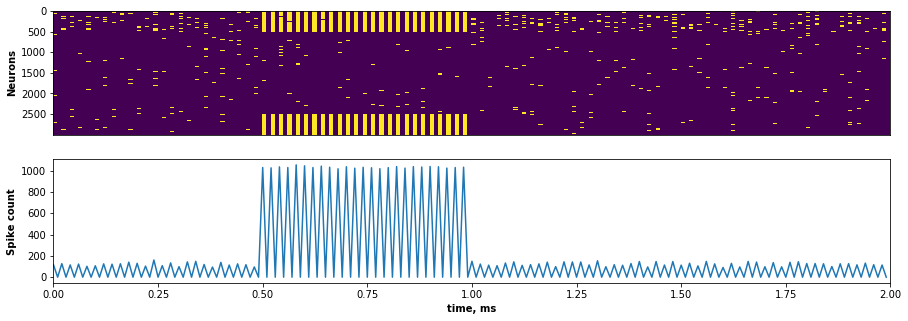

In [2]:
out = np.vstack((out_I, out_E))
f, (ax0, ax1) = plt.subplots(2, 1, figsize=(15,5))
ax0.imshow(out, aspect='auto')
ax0.get_xaxis().set_visible(False)
ax0.set_ylabel('Neurons', weight='bold')
ax1.plot(np.arange(0, T, H), out.sum(axis=0))
ax1.set_xlim(0, T)
ax1.set_xlabel('time, ms', weight='bold')
ax1.set_ylabel('Spike count', weight='bold')


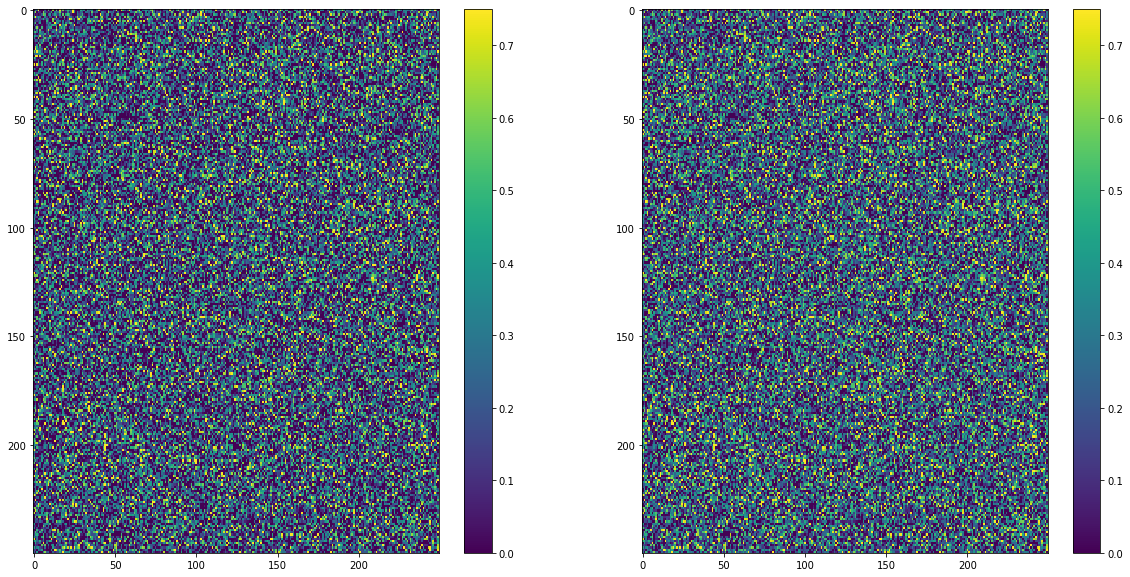

In [72]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(init_J_EE, aspect='auto')
plt.colorbar()
plt.subplot(1,2,2)
plt.colorbar()
plt.imshow(net.J_EE, aspect='auto')

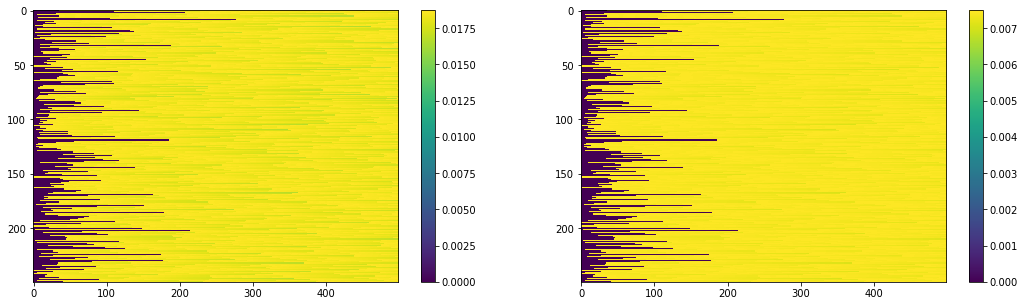

In [70]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.imshow(net.X, aspect='auto')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(net.Y, aspect='auto')
plt.colorbar()

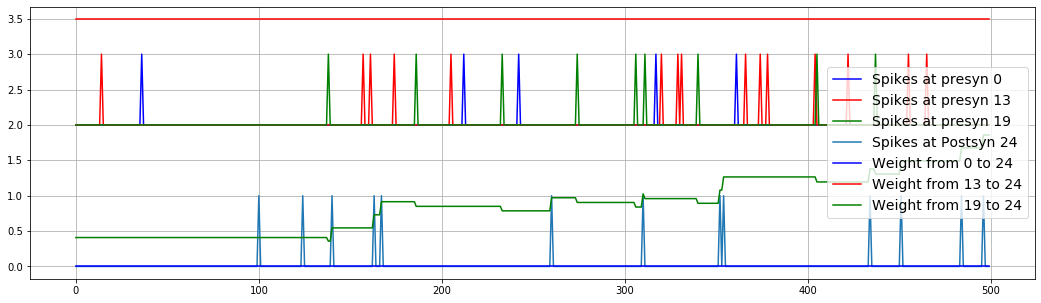

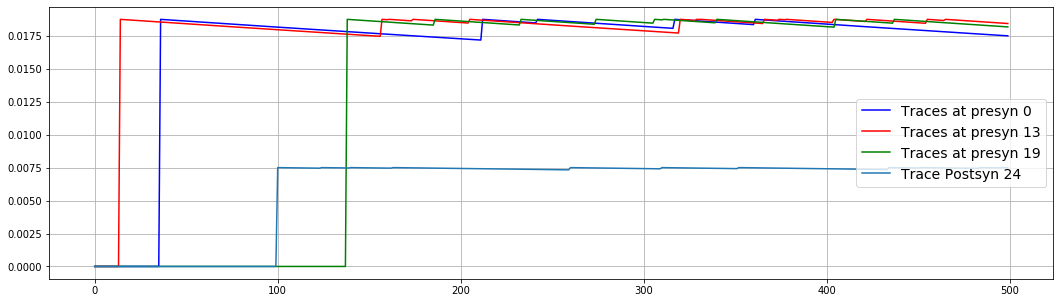

In [71]:
color = ['blue', 'red', 'green']
post = 24
pre = [0, 13, 19]

plt.figure(figsize=(18,5))
for i, c in zip(pre, color):
    plt.plot(out_E[i,:]+2, label='Spikes at presyn {}'.format(i), c=c)

plt.plot(out_E[post,:], label='Spikes at Postsyn {}'.format(post))
# plt.plot(net.Y[post,:]*200, label='Trace Postsyn {}'.format(post))
plt.grid()
# plt.plot(net.X[pre,:]*200, label='Trace Presyn {}'.format(pre))
for i, c in zip(pre, color):
    plt.plot(net.W[post,i,:]*10, label='Weight from {} to {}'.format(i, post), c=c)
plt.legend(fontsize=14, loc='right')


plt.figure(figsize=(18,5))

for i, c in zip(pre, color):
    plt.plot(net.X[i,:], label='Traces at presyn {}'.format(i), c=c)
plt.plot(net.Y[post,:], label='Trace Postsyn {}'.format(post))

plt.grid()
plt.legend(fontsize=14, loc='right')

In [39]:
net.X.shape

(25, 200)

1.0


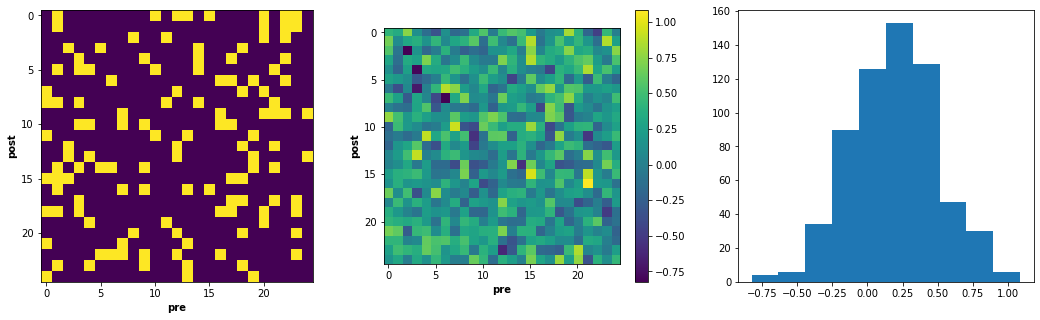

In [45]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(net.c_EE)
plt.ylabel('post', weight='bold')
plt.xlabel('pre', weight='bold')
plt.subplot(1,3,2)
plt.imshow(net.J_EE)
plt.ylabel('post', weight='bold')
plt.xlabel('pre', weight='bold')
plt.colorbar()
plt.subplot(1,3,3)
plt.hist(net.J_EE.flatten())
print(net.c_EE[0,12])

In [50]:
for i in range(2500):
    if np.sum(out_E[i,:]) > 53 and net.c_EE[1,i] == 1:
        print(i)


2286
2368
2425


In [ ]:
f, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(18,9))
pre = np.zeros((1000,))
pre[210] = 1
pre[230] = 1
ax0.plot(pre)
pre_trace = np.convolve(pre,g,mode='same')
ax0.plot(pre_trace)
ax0.set_xlim(190, 300)
ax0.set_title('Pre', weight='bold')

post = np.zeros((1000,))
post[215] = 1
post[217] = 1
post[219] = 1
post[221] = 1
ax1.plot(post)
post_trace = np.convolve(post,g,mode='same')
ax1.plot(post_trace)
ax1.set_xlim(190, 300)
ax1.set_title('Post', weight='bold')

W = np.zeros_like(post_trace)
w = 0
dw = np.zeros_like(post_trace)
for i in range(len(W)):
    dw = pre_trace[i]*post[i] - post_trace[i]*pre[i]
    w += dw
    W[i] = w
ax2.plot(W)
ax2.set_xlim(190, 300)
ax2.set_title('Weight', weight='bold')


<img src="eq.png">

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


tau = 1/0.01 # ms/dt
Cp, Cd = 0.01875, 0.0075
pre = np.zeros((1000,))
pre[210] = 1
pre[230] = 1
post = np.zeros((1000,))
post[215] = 1
post[217] = 1
post[219] = 1
post[221] = 1


W = np.zeros((1000, ))
w = 0


lastPreSpikeTime = -500
lastPostSpikeTime = -500

x = np.zeros((1000, ))
y = np.zeros((1000, ))

for t in range(1000):
    if pre[t] == 1:
        lastPreSpikeTime = t
    x[t] = Cp * np.exp(-(t-lastPreSpikeTime)/tau) # fix tau!!!!
    
    if post[t] == 1:
        lastPostSpikeTime = t
    y[t] = Cd * np.exp(-(t-lastPostSpikeTime)/tau)  # fix tau and Fd !!!! (Log-STDP!!!!)

    dw = x[t]*post[t] - y[t]*pre[t]
    w += dw
    W[t] = w

In [ ]:
f, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(18,9), sharex=True)
ax0.plot(pre)
ax0.plot(x)
ax0.set_title('Pre', weight='bold')

ax1.plot(post)
ax1.plot(y)
ax1.set_title('Post', weight='bold')

ax2.plot(W)
ax2.set_title('Weight', weight='bold')
plt.xlim(190, 300)


In [ ]:
lastPreSpikeTime

In [ ]:
lastPostreSpikeTime